# Getting Started - RocketPy in Colab


We start by setting up our environment. To run this notebook, we will need:

- RocketPy
- Data files (we will download RocketPy's data from github)

Therefore, let's run the following lines of code:

In [3]:
!pip install rocketpy
#!curl -o NACA0012-radians.txt https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/data/airfoils/NACA0012-radians.txt
#!curl -o Cesaroni_M1670.eng https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/data/motors/cesaroni/Cesaroni_M1670.eng
#!curl -o powerOffDragCurve.csv https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/data/rockets/calisto/powerOffDragCurve.csv
#!curl -o powerOnDragCurve.csv https://raw.githubusercontent.com/RocketPy-Team/RocketPy/master/data/rockets/calisto/powerOnDragCurve.csv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.2/382.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.8 MB/s eta 0:00:00
  Created wheel for simplekml: filename=simplekml-1.3.6-py3-none-any.whl size=65860 sha256=203926f5768cb48db7881af2da46868453db5cedb6e8348de88356fc6ab8b379
  Stored in directory: /root/.cache/pip/wheels/83/ee/f2/65cecfd948f1429ead035fd6d56bc6bd6574a636ddc4d65cbd
Successfully built simplekml


Now we can start!

Here we go through a simplified rocket trajectory simulation to get you started. Let's start by importing the rocketpy module.


In [4]:
from rocketpy import Environment, Flight, Rocket, SolidMotor

It is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.


In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

## Setting Up a Simulation


### Creating an Environment for Spaceport America



The `Environment` class is used to define the atmosphere, the winds, and the gravity models.

You can find more information about the `Environment` class in the [Environment Class Usage Docs](https://docs.rocketpy.org/en/latest/notebooks/environment/environment_class_usage.html).

In [5]:
env = Environment(latitude=41.77539290058019, longitude=-86.57246683558242, elevation=692)

To get weather data from the GFS forecast, available online, we run the following lines.

First, we set tomorrow's date.


In [35]:
import datetime
from datetime import date

my_date = date(2025, 12, 17) # Date as requested
# tomorrow = datetime.date.today() + datetime.timedelta(days=1)

env.set_atmospheric_model(type="standard_atmosphere")

env.set_date(
    (my_date.year, my_date.month, my_date.day, 17)
)  # Hour given in UTC time


Then, we tell env to use a GFS forecast to get the atmospheric conditions for flight.

Don't mind the warning, it just means that not all variables, such as wind speed or atmospheric temperature, are available at all altitudes given by the forecast.


In [18]:
# The line below is commented out because the GFS forecast is not available for the chosen date (2025-12-25).
# A StandardAtmosphere model has been set in the previous cell to allow the simulation to proceed with the requested date.
# env.set_atmospheric_model(type="Forecast", file="GFS")

We can see what the weather will look like by calling the info method!



Gravity Details

Acceleration of gravity at surface level:    9.8012 m/s²
Acceleration of gravity at  80.000 km (ASL): 9.5610 m/s²


Launch Site Details

Launch Date: 2025-12-17 17:00:00 UTC
Launch Site Latitude: 41.77539°
Launch Site Longitude: -86.57247°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 36799.62 W    4639870.44 N
Launch Site UTM zone: 17T
Launch Site Surface Elevation: 692.0 m


Atmospheric Model Details

Atmospheric Model Type: standard_atmosphere
standard_atmosphere Maximum Height: 80.000 km

Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 0.00°
Surface Wind Heading: 0.00°
Surface Pressure: 932.94 hPa
Surface Temperature: 283.66 K
Surface Air Density: 1.146 kg/m³
Surface Speed of Sound: 337.45 m/s


Earth Model Details

Earth Radius at Launch site: 6368.69 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034


Atmospheric Model Plots



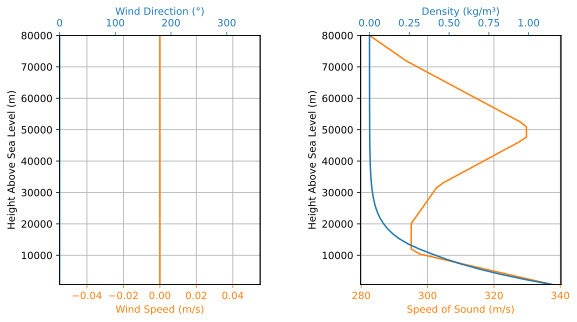

In [36]:
env.info()

### Creating a Motor

A solid rocket motor is used in this case. To create a motor, the SolidMotor class is used and the required arguments are given.

The SolidMotor class requires the user to have a thrust curve ready. This can come either from a .eng file for a commercial motor, such as below, or a .csv file from a static test measurement.

Besides the thrust curve, other parameters such as grain properties and nozzle dimensions must also be given.

See [Solid Motor Class Usage Docs](https://docs.rocketpy.org/en/latest/user/motors/solidmotor.html) for more information.


In [37]:
Aerotech_K1103X = SolidMotor(
    thrust_source="/content/AeroTech_K1103X.eng",  # your thrust curve file

    # Physical & inertial
    dry_mass=1.459 - 0.830,     # Total – propellant (kg)
    dry_inertia=(0.15, 0.15, 0.005),

    # Geometry
    nozzle_radius=11 / 1000,    # approx from designation (m)
    throat_radius=11 / 1000,    # approx (m)
    grain_number=5,
    grain_density=1815,         # typical APCP density (kg/m3)
    grain_outer_radius=27 / 1000,     # outer radius ~27 mm (fits 54 mm motor)
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.20,  # approximate position (fraction of length)
    center_of_dry_mass_position=0.20,     # approximate (adjust with CAD if needed)

    # Timing
    burn_time=1.6,                 # from certified data

    # Orientation
    coordinate_system_orientation="nozzle_to_combustion_chamber",
    nozzle_position=0,             # bottom of motor
)


In [ ]:
Aerotech_K1103X = SolidMotor(
    thrust_source="/content/AeroTech_K1103X.eng",  # your thrust curve file

    # Physical & inertial
    dry_mass=1.459 - 0.830,     # Total – propellant (kg)
    dry_inertia=(0.15, 0.15, 0.005),

    # Geometry
    nozzle_radius=11 / 1000,    # approx from designation (m)
    throat_radius=11 / 1000,    # approx (m)
    grain_number=5,
    grain_density=1815,         # typical APCP density (kg/m3)
    grain_outer_radius=27 / 1000,     # outer radius ~27 mm (fits 54 mm motor)
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.20,  # approximate position (fraction of length)
    center_of_dry_mass_position=0.20,     # approximate (adjust with CAD if needed)

    # Timing
    burn_time=1.6,                 # from certified data

    # Orientation
    coordinate_system_orientation="nozzle_to_combustion_chamber",
    nozzle_position=0,             # bottom of motor
)


**Pay special attention to *position* related parameters:**
More details on [Positions and Coordinate Systems](https://docs.rocketpy.org/en/latest/user/positions.html)


To see what our thrust curve looks like, along with other import properties, we invoke the info method yet again. You may try the all_info method if you want more information all at once!


Nozzle Details
Nozzle Radius: 0.011 m
Nozzle Throat Radius: 0.011 m

Grain Details
Number of Grains: 5
Grain Spacing: 0.005 m
Grain Density: 1815 kg/m3
Grain Outer Radius: 0.027 m
Grain Inner Radius: 0.015 m
Grain Height: 0.12 m
Grain Volume: 0.000 m3
Grain Mass: 0.345 kg

Motor Details
Total Burning Time: 1.6 s
Total Propellant Mass: 1.724 kg
Structural Mass Ratio: 0.267
Average Propellant Exhaust Velocity: 1044.485 m/s
Average Thrust: 1125.617 N
Maximum Thrust: 1619.8 N at 0.028 s after ignition.
Total Impulse: 1800.987 Ns



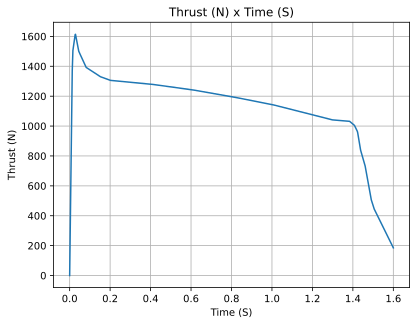

In [38]:
Aerotech_K1103X.info()

### Creating a Rocket


A rocket is composed of several components. Namely, we must have a motor (good thing we have the Pro75M1670 ready), a couple of aerodynamic surfaces (nose cone, fins and tail) and parachutes (if we are not launching a missile).

You can find more information about the `Rocket` class in the [Rocket Class Usage Docs](https://docs.rocketpy.org/en/latest/user/rocket.html).

Let's start by initializing our rocket, named Calisto, entering inertia properties, some dimensions and drag curves.

**Pay special attention to *position* related parameters:**
More details on [Positions and Coordinate Systems](https://docs.rocketpy.org/en/latest/user/positions.html)



In [ ]:
Pixel_1 = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="powerOffDragCurve.csv",
    power_on_drag="powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

rail_buttons = Pixel_1.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.618,
    angular_position=45,
)

To add the motor to our rocket we need only inform what motor we are adding (Pro75M1670) and inform the position, in meters, of the motor's nozzle exit area relative to the previously defined coordinate system.


In [ ]:
Pixel_1.add_motor(Aerotech_K1103X, position=-1.255)

#### Adding Aerodynamic Surfaces


Now we define the aerodynamic surfaces. They are really straight forward with special attention needed only for the position values. Here is a quick guide:

- The positions given **must** be relative to the same coordinate system as the rockets;
- Position of the Nosecone refers to the tip of the nose;
- Position of fins refers to the point belonging to the root chord which is highest in the rocket coordinate system;
- Position of the tail the point belonging to the tail which is highest in the rocket coordinate system.

See more details in [Positions and Coordinate Systems](https://docs.rocketpy.org/en/latest/user/positions.html)

In [ ]:
nose_cone = Pixel_1.add_nose(length=0.55829, kind="vonKarman", position=1.278)

fin_set = Pixel_1.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=("NACA0012-radians.txt", "radians"),
)

tail = Pixel_1.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)

To see all information regarding the rocket we just defined we run:


In [ ]:
Pixel_1.all_info()

#### Adding Parachutes


Finally, we have parachutes! Calisto will have two parachutes, Drogue and Main. The Drogue parachute will open at apogee while the Main parachute will open at 800m above ground level

For more details see [Adding Parachutes](https://docs.rocketpy.org/en/latest/user/rocket.html#adding-parachutes)

In [ ]:
Main = Pixel_1.add_parachute(
    "Main",
    cd_s=10.0,
    trigger=700,
    sampling_rate=105,
    lag=1.0,
    noise=(0, 8.3, 0.5),
)

Drogue = Pixel_1.add_parachute(
    "Drogue",
    cd_s=1.0,
    trigger="apogee",
    sampling_rate=105,
    lag=1.0,
    noise=(0, 8.3, 0.5),
)

Just be careful if you run this last cell multiple times! If you do so, your rocket will end up with lots of parachutes which activate together, which may cause problems during the flight simulation. We advise you to re-run all cells which define our rocket before running this, preventing unwanted old parachutes. Alternatively, you can run the following lines to remove parachutes.

```python
Calisto.parachutes.remove(Drogue)
Calisto.parachutes.remove(Main)
```


## Simulating a Flight

Simulating a flight trajectory is as simple as initializing a Flight class object givin the rocket and environnement set up above as inputs. The launch rail inclination and heading are also given here.


In [ ]:
test_flight = Flight(
    rocket=Pixel_1, environment=env, rail_length=5.2, inclination=85, heading=0
)

## Analyzing the Results

RocketPy gives you many plots, thats for sure! They are divided into sections to keep them organized. Alternatively, see the Flight class documentation to see how to get plots for specific variables only, instead of all of them at once.


In [ ]:
test_flight.all_info()

Export Flight Trajectory to a .kml file so it can be opened on Google Earth


In [ ]:
test_flight.export_kml(
    file_name="trajectory.kml",
    extrude=True,
    altitude_mode="relative_to_ground",
)

## Using Simulation for Design

Here, we go through a couple of examples which make use of RocketPy in cool ways to help us design our rocket.


### Apogee as a Function of Mass

This one is a classic one! We always need to know how much our rocket's apogee will change when our payload gets heavier.


In [ ]:
from rocketpy.utilities import apogee_by_mass

apogee_by_mass(flight=test_flight, min_mass=5, max_mass=20, points=10, plot=True)

### Out of Rail Speed as a Function of Mass

Lets make a really important plot. Out of rail speed is the speed our rocket has when it is leaving the launch rail. This is crucial to make sure it can fly safely after leaving the rail. A common rule of thumb is that our rocket's out of rail speed should be 4 times the wind speed so that it does not stall and become unstable.


In [ ]:
from rocketpy.utilities import liftoff_speed_by_mass

liftoff_speed_by_mass(flight=test_flight, min_mass=5, max_mass=20, points=10, plot=True)

### Dynamic Stability Analysis

Ever wondered how static stability translates into dynamic stability? Different static margins result in different dynamic behavior, which also depends on the rocket's rotational inertial.

Let's make use of RocketPy's helper class called Function to explore how the dynamic stability of Calisto varies if we change the fins span by a certain factor.


In [ ]:
# Helper class
import copy

from rocketpy import Function

# Prepare a copy of the rocket
calisto2 = copy.deepcopy(Pixel_1)

# Prepare Environment Class
custom_env = Environment()
custom_env.set_atmospheric_model(type="custom_atmosphere", wind_v=-5)

# Simulate Different Static Margins by Varying Fin Position
simulation_results = []

for factor in [-0.5, -0.2, 0.1, 0.4, 0.7]:
    # Modify rocket fin set by removing previous one and adding new one
    calisto2.aerodynamic_surfaces.pop(-1)

    fin_set = calisto2.add_trapezoidal_fins(
        n=4,
        root_chord=0.120,
        tip_chord=0.040,
        span=0.100,
        position=-1.04956 * factor,
    )
    # Simulate
    print(
        "Simulating Rocket with Static Margin of {:1.3f}->{:1.3f} c".format(
            calisto2.static_margin(0),
            calisto2.static_margin(calisto2.motor.burn_out_time),
        )
    )
    test_flight = Flight(
        rocket=calisto2,
        environment=custom_env,
        rail_length=5.2,
        inclination=90,
        heading=0,
        max_time_step=0.01,
        max_time=5,
        terminate_on_apogee=True,
        verbose=True,
    )
    # Store Results
    static_margin_at_ignition = calisto2.static_margin(0)
    static_margin_at_out_of_rail = calisto2.static_margin(test_flight.out_of_rail_time)
    static_margin_at_steady_state = calisto2.static_margin(test_flight.t_final)
    simulation_results += [
        (
            test_flight.attitude_angle,
            "{:1.2f} c | {:1.2f} c | {:1.2f} c".format(
                static_margin_at_ignition,
                static_margin_at_out_of_rail,
                static_margin_at_steady_state,
            ),
        )
    ]

Function.compare_plots(
    simulation_results,
    lower=0,
    upper=1.5,
    xlabel="Time (s)",
    ylabel="Attitude Angle (deg)",
)

### Characteristic Frequency Calculation

Here we analyse the characteristic frequency of oscillation of our rocket just as it leaves the launch rail. Note that when we ran test_flight.all_info(), one of the plots already showed us the frequency spectrum of our flight. Here, however, we have more control of what we are plotting.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate first 5 seconds of Flight
flight = Flight(
    rocket=Pixel_1,
    environment=env,
    rail_length=5.2,
    inclination=90,
    heading=0,
    max_time_step=0.01,
    max_time=5,
)

# Perform a Fourier Analysis
Fs = 100.0
# sampling rate
Ts = 1.0 / Fs
# sampling interval
t = np.arange(1, 400, Ts)  # time vector
ff = 5
# frequency of the signal
y = flight.attitude_angle(t) - np.mean(flight.attitude_angle(t))
n = len(y)  # length of the signal
k = np.arange(n)
T = n / Fs
frq = k / T  # two sides frequency range
frq = frq[range(n // 2)]  # one side frequency range
Y = np.fft.fft(y) / n  # fft computing and normalization
Y = Y[range(n // 2)]

# Create the plot
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, y)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Signal")
ax[0].set_xlim((0, 5))
ax[0].grid()
ax[1].plot(frq, abs(Y), "r")  # plotting the spectrum
ax[1].set_xlabel("Freq (Hz)")
ax[1].set_ylabel("|Y(freq)|")
ax[1].set_xlim((0, 5))
ax[1].grid()
plt.subplots_adjust(hspace=0.5)
plt.show()